In [1]:
from pytrends.request import TrendReq
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objects as go
import plotly.offline as pyo
from scipy import signal
import scipy.cluster.hierarchy as spc
from pandas import read_excel
from ipywidgets import widgets
from ipywidgets import interactive, HBox, VBox
import plotly.io as pio
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans

# Plan

1. Introduction
2. Ecolo
3. Economic
4. Animale care
5. Gather
6. What's next ?

# 4. Animal care

In [2]:
country_list = ["FR","BE","BG","CY","CZ","DE","DK","EE","ES","FI","AT","GB","GR","HR","HU","IE","IT","LT","LU","LV","MT","NL","PL","PT","RO","SE","SI","SK"]
country_list_iso = ["FRA","BEL","BGR","CYP","CZE","DEU","DNK","EST","ESP","FIN","AUT","GBR","GRC","HRV","HUN","IRL","ITA","LTU","LUX","LVA","MLT","NLD","POL","PRT","ROU","SWE","SVN","SVK"]

In [3]:
pytrends = TrendReq(hl='en-US', tz=360)

#list topics 
kw_list = []
kw_list.append(["/m/032nch"]) #cruauté envers les animaux, Sujet
kw_list.append(["l214"])
kw_list.append(["/m/047v0jr"]) #abattage
kw_list.append(["/m/07628"]) #spécisme
kw_list.append(["/m/07_lq"]) #cuisine vegetarienne
kw_list.append(["/m/07_jd"]) #végétarisme
kw_list.append(["/m/07_hy"]) #véganisme
kw_list.append(["/m/020953"]) #substitut de viande

In [4]:
#loading data
df_animal_cruelty = pd.read_pickle("./data_vinc/GoogleTrend0.pkl")
df_l214 = pd.read_pickle("./data_vinc/GoogleTrend1.pkl")
df_abattage = pd.read_pickle("./data_vinc/GoogleTrend2.pkl")
df_specism = pd.read_pickle("./data_vinc/GoogleTrend3.pkl")
df_vegan_cook = pd.read_pickle("./data_vinc/GoogleTrend4.pkl")
df_vegetarism = pd.read_pickle("./data_vinc/GoogleTrend5.pkl")
df_veganism = pd.read_pickle("./data_vinc/GoogleTrend6.pkl")
df_meat_substitute = pd.read_pickle("./data_vinc/GoogleTrend7.pkl")

In [10]:
def plot_lines(df,value_smooth, title):
    fig = go.Figure()
    for x in df.columns:
        if value_smooth == 0:
            fig.add_trace(go.Scatter(x=df.index, y=df[x], mode='lines',name=x))
        else:
            fig.add_trace(go.Scatter(x=df.index, y=signal.savgol_filter(df[x],value_smooth, 3), mode='lines',name=x))
    fig.update_layout(title_text=title)
    fig.show()

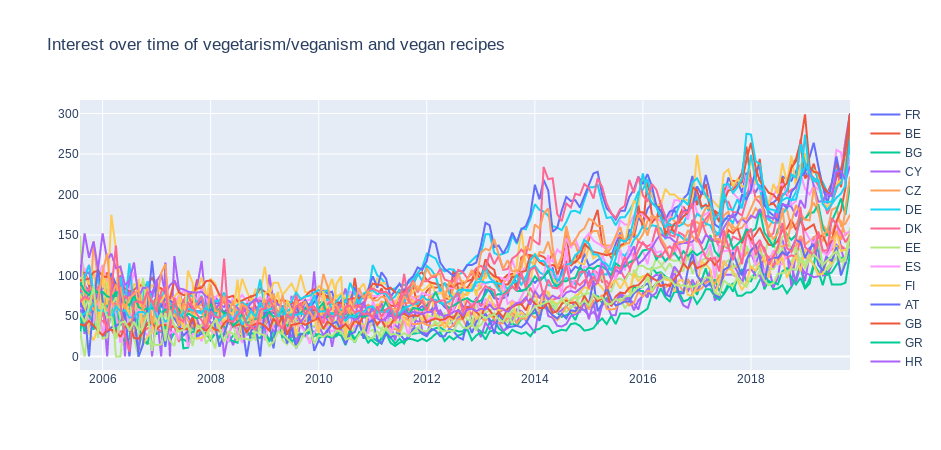

In [31]:
    plot_lines((df_veganism+df_vegetarism+df_vegan_cook), 0, "Interest over time of vegetarism/veganism and vegan recipes")

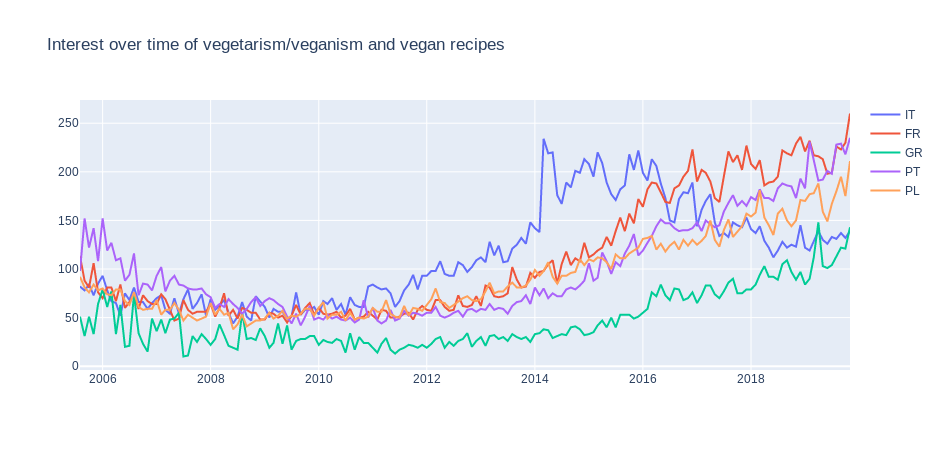

In [12]:
plot_lines((df_veganism+df_vegetarism+df_vegan_cook)[['IT', 'FR', 'GR', 'PT', 'PL']], 0, "Interest over time of vegetarism/veganism and vegan recipes")

As we can see the interest for this topic increased last 10 years, but as we saw before ...
The most interesting fact with google trend is the spikes from a period to another:

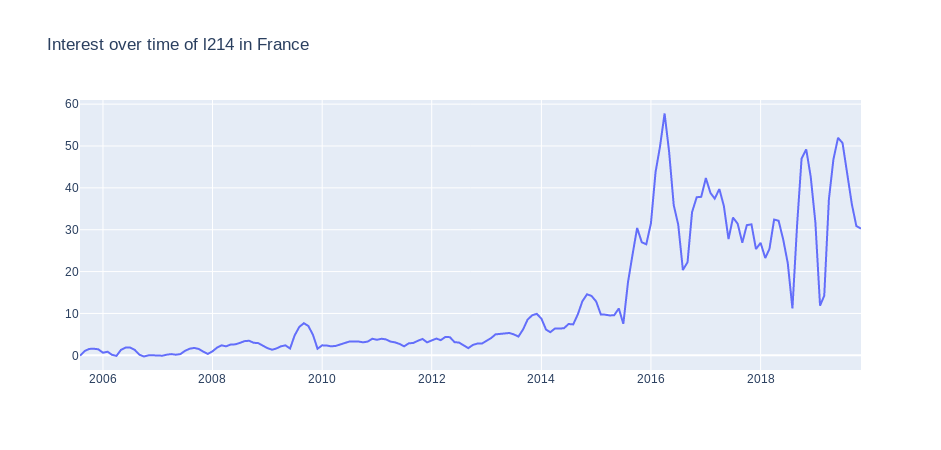

In [15]:
plot_lines(df_l214[['FR']], 7, "Interest over time of l214 in France")

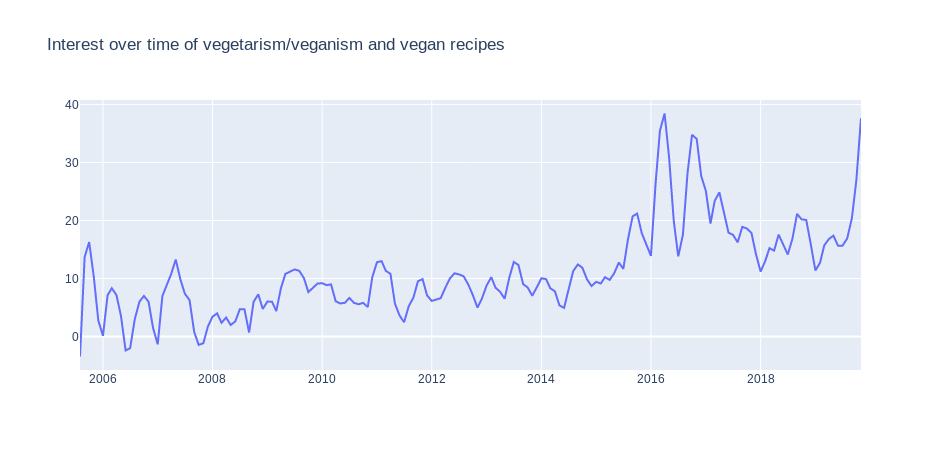

In [18]:
plot_lines(df_meat_substitute[['FR']], 7, "Interest over time of vegetarism/veganism and vegan recipes")

Here we can see that something happened in France in April 2016 with the association L214, even the research for meat substitute has increased at that moment. What would be interesting is to find the exact event that happened at that moment.

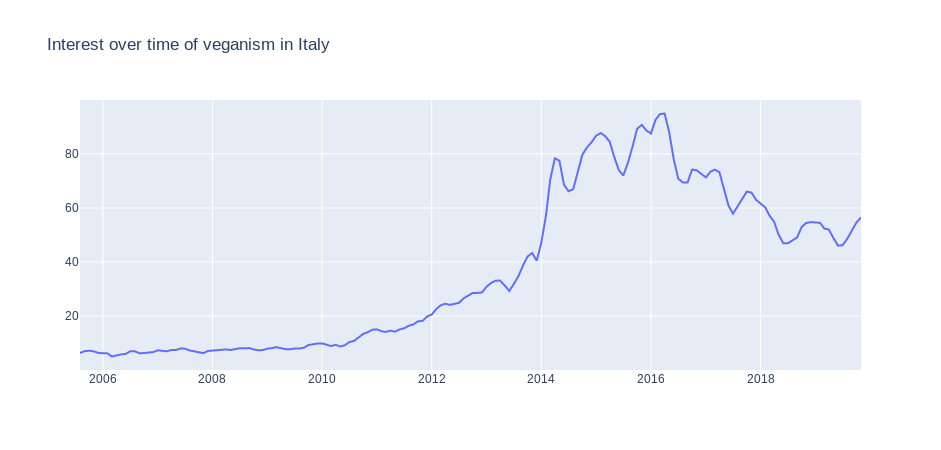

In [16]:
plot_lines(df_veganism[['IT']], 7, "Interest over time of veganism in Italy")

Even in Italy the interest for veganism increase significantly between 2013 and 2014. 

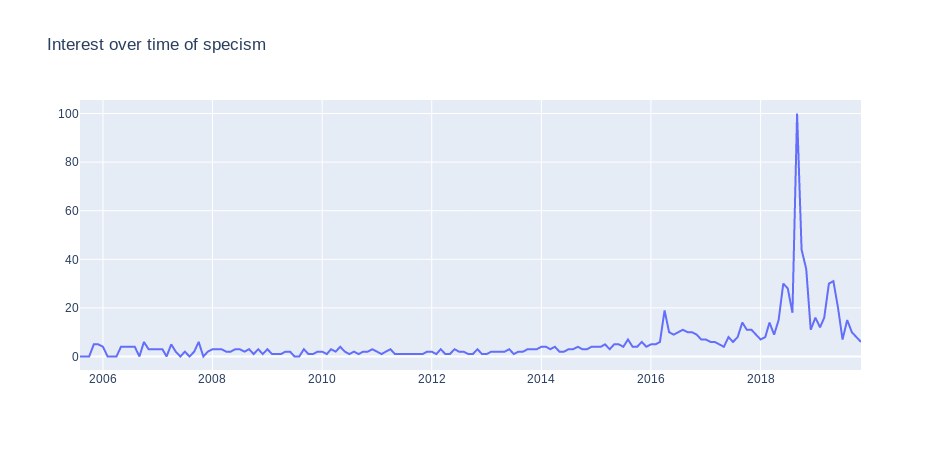

In [33]:
plot_lines(df_specism[['FR']], 0, "Interest over time of specism")

Some event clearly happenened when those researches exploded.
What are the triggers events for those researchs ?
But can we see an actual change on the meat consumption ? 
Does the fact that people acknowledge theirselves on those subjects make an actual impact ?

Also we can try to see some similar behaviours in those interests? K-means algorithm might be a first idea to cluster the differents countries:

In [ ]:
#cluster countries based on correlation measure
def getIdx(corr,variableTweak):
    pdist = spc.distance.pdist(corr)
    linkage = spc.linkage(pdist, method='complete')
    idx = spc.fcluster(linkage, variableTweak * pdist.max(), 'distance')
    return idx

def getGroupe(number,idx):
    groupe = []
    for i in range(0,len(idx)):
        x = idx[i]
        if x == number:
            groupe.append(i)
    return groupe

def plotDifferentGroup(idx,dfPlot,indicePlot, title):
    for i in range(1,max(idx)+1):
        df1 = dfPlot[dfPlot.columns[getGroupe(i,idx)]]
        plot_lines(df1,indicePlot, title)

def plotMapStatic(idx, title):
    fig = go.Figure(data=go.Choropleth(
        locations=country_list_iso, # Spatial coordinates
        z = idx, # Data to be color-coded
        locationmode = 'ISO-3', # set of locations match entries in `locations`
        colorscale="Blugrn",
        colorbar_title = "Millions USD",
        showscale = False,
    ))

    fig.update_layout(
        title_text = title,
        geo_scope='europe', # limite map scope to USA
        autosize=False,
        width=800,
        height=800,
        dragmode=False
    )
    fig.show()
    
def plotByGroup(df, title, threshold=0.5, method='hierarchical', n_clusters=3):
    df_corr= df.corr(method='kendall')
    idx = None
    if method== 'hierarchical':
        idx = getIdx(df_corr, threshold)
    else:
        idx=getKMeansGroups(df, n_clusters)+1
    plotDifferentGroup(idx, df, 11, title)
    plotMapStatic(idx, 'Clustering by interest on subject')
    
    
def getKMeansGroups(df, n_clusters=3):
    k_means = KMeans(n_clusters=n_clusters, random_state=0).fit(df.transpose().values)
    return k_means.predict(df.transpose().values)

In [ ]:
plotByGroup((df_veganism+df_vegetarism+df_vegan_cook), 'title temp', n_clusters=2, method='kmeans')

In [ ]:
plotByGroup((df_veganism+df_vegan_cook), 'title temp', n_clusters=3, method='kmeans')

As we can see, even if we have high dimensional data, the k-means split we obtained make sense. Even more, when we display the countries that are grouped together, we can see that they are geographicaly close to each other. That might be an avenue worth to explore.
They are also some spike in the trends. For example here for the topic 'L214' in France, which is an association about animal care: